In [ ]:
!pip install pyfin

!pip install 

  Using cached pyfin-1.0.0a1-py3-none-any.whl.metadata (861 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pyfin]


In [67]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import numpy as np

In [100]:

# List of ETF tickers to compare (US and European)
etfs = ["SPY", "QQQ", "EWJ" ,"FXI","XLK","XLF", "KWEB"]

for ticker_symbol in etfs:
    ticker = yf.Ticker(ticker_symbol)
    expiries = ticker.options

    print(f"\n=== {ticker_symbol} ===")
    print(f"Available Expirations ({len(expiries)}): {expiries}")

    if expiries:
        # Get option chain for the earliest expiry
        chain = ticker.option_chain(expiries[0])
        print(f"\nOptions for expiry: {expiries[0]}")
        print("Calls:")
        print(chain.calls.head())
        print("Puts:")
        print(chain.puts.head())
    else:
        print("No options data available.")



=== SPY ===
Available Expirations (29): ('2025-07-23', '2025-07-24', '2025-07-25', '2025-07-28', '2025-07-29', '2025-07-30', '2025-07-31', '2025-08-01', '2025-08-08', '2025-08-15', '2025-08-22', '2025-08-29', '2025-09-19', '2025-09-30', '2025-10-17', '2025-10-31', '2025-11-21', '2025-11-28', '2025-12-19', '2025-12-31', '2026-01-16', '2026-03-20', '2026-03-31', '2026-06-18', '2026-06-30', '2026-09-18', '2026-12-18', '2027-01-15', '2027-12-17')

Options for expiry: 2025-07-23
Calls:
       contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  SPY250723C00500000 2025-07-17 17:48:18+00:00   500.0     127.51  130.46   
1  SPY250723C00520000 2025-07-15 16:24:54+00:00   520.0     105.11  110.39   
2  SPY250723C00550000 2025-07-22 15:04:05+00:00   550.0      77.85   80.65   
3  SPY250723C00560000 2025-07-23 14:23:38+00:00   560.0      70.28   71.75   
4  SPY250723C00575000 2025-07-23 16:00:37+00:00   575.0      56.97   55.59   

      ask    change  percentChange  volume  

In [101]:

# List of ETF tickers to compare (US and European)
etfs = ["SPY", "QQQ", "EWJ" ,"FXI","XLK","XLF", "KWEB"]

all_options = []  # To store all option data

for ticker_symbol in etfs:
    ticker = yf.Ticker(ticker_symbol)
    expiries = ticker.options
    spot_price = ticker.history(period="1d")['Close'].iloc[-1]
    
    if expiries:
        for expiry in expiries:
            expiration_date = datetime.strptime(expiry, "%Y-%m-%d")
            time_to_expiry = (expiration_date - datetime.now()).days / 365.0  # in years

            chain = ticker.option_chain(expiry)

            # Process Calls
            calls = chain.calls.copy()
            calls['option_type'] = 'call'
            calls['expiration'] = expiration_date
            calls['time_to_expiry'] = time_to_expiry
            calls['underlying_price'] = spot_price
            # Mid price as average of bid and ask
            calls['mid_price'] = (calls['bid'] + calls['ask']) / 2

            # Process Puts
            puts = chain.puts.copy()
            puts['option_type'] = 'put'
            puts['expiration'] = expiration_date
            puts['time_to_expiry'] = time_to_expiry
            puts['underlying_price'] = spot_price
            puts['mid_price'] = (puts['bid'] + puts['ask']) / 2

            # Combine and append
            option_data = pd.concat([calls, puts], ignore_index=True)

            # Select relevant columns only
            option_data = option_data[['strike', 'bid', 'ask', 'mid_price', 'option_type', 'expiration', 'impliedVolatility', 'underlying_price', 'time_to_expiry']]
            
            option_data['ticker'] = ticker_symbol

            all_options.append(option_data)
    else:
        print(f"No options data available for {ticker_symbol}")

# Combine all option data for all tickers and expiries into one DataFrame
options_df = pd.concat(all_options, ignore_index=True)

print(options_df.head(20))


    strike     bid     ask  mid_price option_type expiration  \
0    500.0  130.46  132.94    131.700        call 2025-07-23   
1    520.0  110.39  112.96    111.675        call 2025-07-23   
2    550.0   80.65   82.40     81.525        call 2025-07-23   
3    560.0   71.75   71.83     71.790        call 2025-07-23   
4    575.0   55.59   57.63     56.610        call 2025-07-23   
5    585.0   46.77   47.72     47.245        call 2025-07-23   
6    590.0   41.68   41.75     41.715        call 2025-07-23   
7    591.0   39.69   41.72     40.705        call 2025-07-23   
8    592.0   39.67   40.72     40.195        call 2025-07-23   
9    595.0   36.66   36.77     36.715        call 2025-07-23   
10   597.0   33.60   35.73     34.665        call 2025-07-23   
11   598.0   33.75   34.72     34.235        call 2025-07-23   
12   600.0   31.77   32.72     32.245        call 2025-07-23   
13   601.0   30.68   31.63     31.155        call 2025-07-23   
14   602.0   29.75   30.72     30.235   

In [102]:
options_df.to_csv('Data/options_data.csv', index=False)

In [104]:
options_df = pd.read_csv('Data/options_data_1.csv')
# removed implied_volatility 0 and 0.00001

In [143]:
options_df['impliedVolatility'] = pd.to_numeric(options_df['impliedVolatility'], errors='coerce')
mask = (
    options_df['mid_price'].notna() &
    options_df['impliedVolatility'].notna() &
    options_df['strike'].notna() &
    (options_df['mid_price'] > 0) &
    (options_df['impliedVolatility'] > 0.01) &  
    (options_df['time_to_expiry'] > 14/365) & (options_df['time_to_expiry'] <= 1.0) &
    (options_df['bid'] > 0) &
    ((options_df['ask'] - options_df['bid']) / options_df['mid_price'] < 0.15)
)

# Apply mask once
options_df = options_df.loc[mask].copy()
options_df['moneyness'] = options_df['strike'] / options_df['underlying_price']
print(f"After filtering, {len(options_df)} options remain.")


After filtering, 7597 options remain.


In [141]:
options_df

,strike,bid,ask,mid_price,option_type,expiration,impliedVolatility,underlying_price,time_to_expiry,ticker,moneyness
1513,245.0,386.28,388.92,387.600,call,2025-08-15,1.775880,632.724976,0.060274,SPY,0.387214
1514,250.0,381.23,384.00,382.615,call,2025-08-15,1.757814,632.724976,0.060274,SPY,0.395116
1515,325.0,306.43,309.24,307.835,call,2025-08-15,0.949219,632.724976,0.060274,SPY,0.513651
1516,330.0,301.56,304.26,302.910,call,2025-08-15,0.983399,632.724976,0.060274,SPY,0.521554
1517,335.0,296.49,299.29,297.890,call,2025-08-15,0.950196,632.724976,0.060274,SPY,0.529456
...,...,...,...,...,...,...,...,...,...,...,...
16435,40.0,4.35,4.55,4.450,call,2026-07-17,0.386481,37.143101,0.980822,KWEB,1.076916
16436,41.0,4.00,4.20,4.100,call,2026-07-17,0.385626,37.143101,0.980822,KWEB,1.103839
16454,36.0,3.90,4.10,4.000,put,2026-07-17,0.322394,37.143101,0.980822,KWEB,0.969224
16455,38.0,4.90,5.10,5.000,put,2026-07-17,0.314460,37.143101,0.980822,KWEB,1.023070


In [109]:
unique_ex = options_df.groupby('ticker')['expiration'].nunique()
print(unique_ex)


ticker
EWJ      4
FXI     20
KWEB    13
QQQ     21
SPY     22
XLF     16
XLK     11
Name: expiration, dtype: int64


In [110]:
print(options_df.groupby('ticker')['expiration'].agg(['min', 'max']))


               min         max
ticker                        
EWJ     2025-08-15  2026-01-16
FXI     2025-08-01  2026-07-17
KWEB    2025-08-01  2026-07-17
QQQ     2025-07-28  2026-06-30
SPY     2025-07-28  2026-06-30
XLF     2025-08-01  2026-06-30
XLK     2025-08-01  2026-06-18


In [ ]:
tickers = options_df['ticker'].unique()

for ticker in tickers:
    ticker_data = options_df[options_df['ticker'] == ticker]
    expirations = ticker_data['expiration'].unique()
    
    for expiry in expirations:
        expiry_data = ticker_data[ticker_data['expiration'] == expiry]

        plt.figure(figsize=(10, 6))
        plt.title(f'Volatility Smile for {ticker} - Expiry: {expiry}')
        
        # Plot Calls
        calls = expiry_data[expiry_data['option_type'] == 'call']
        plt.plot(calls['moneyness'], calls['impliedVolatility'], label='Calls', marker='o', linestyle='-', color='blue')
        
        # Plot Puts
        puts = expiry_data[expiry_data['option_type'] == 'put']
        plt.plot(puts['moneyness'], puts['impliedVolatility'], label='Puts', marker='x', linestyle='--', color='red')

        plt.xlabel('Moneyness (Strike / Underlying Price)')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()


# 2D

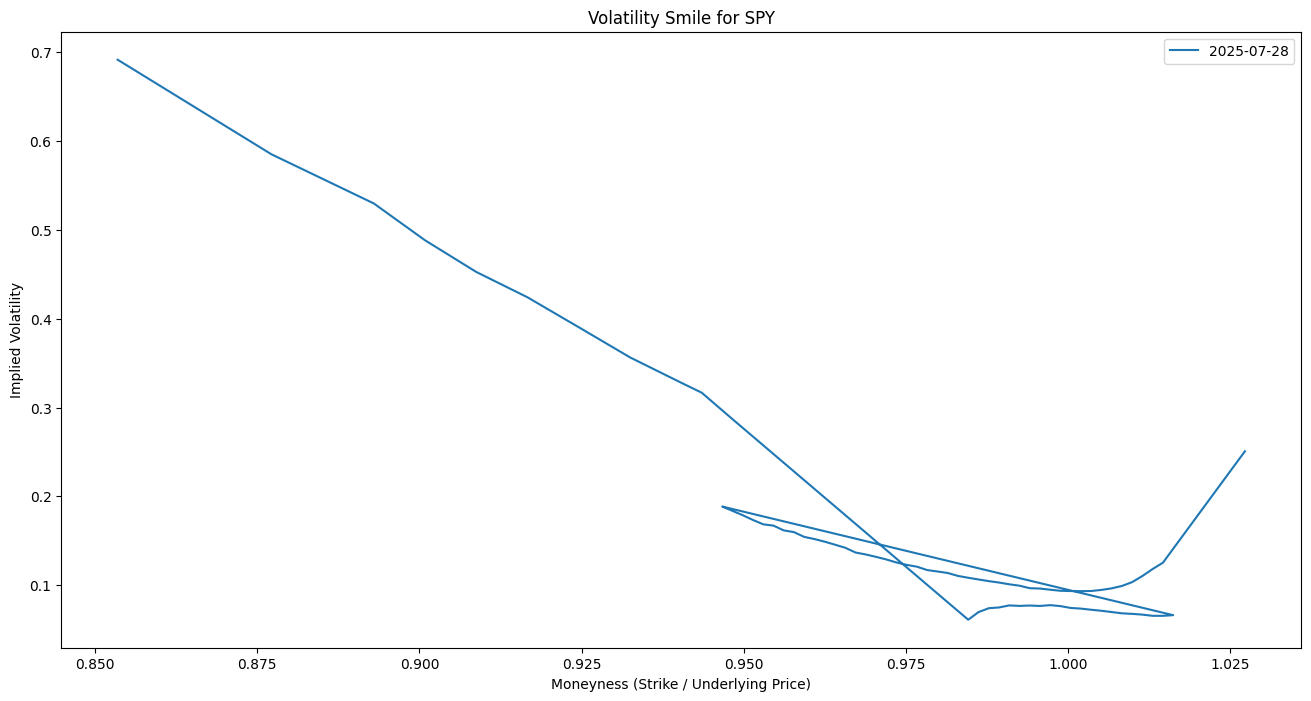

In [114]:

ticker = 'SPY'
subset = options_df[options_df['ticker'] == ticker]

# Select a few expirations for clarity
expiries = sorted(subset['expiration'].unique())[:1]  # first 5 expirations

plt.figure(figsize=(16,8))

for expiry in expiries:
    data = subset[subset['expiration'] == expiry]
    plt.plot(data['strike'] / data['underlying_price'], data['impliedVolatility'], label=str(expiry))

plt.xlabel('Moneyness (Strike / Underlying Price)')
plt.ylabel('Implied Volatility')
plt.title(f'Volatility Smile for {ticker}')
plt.legend()
plt.show()


# 3D

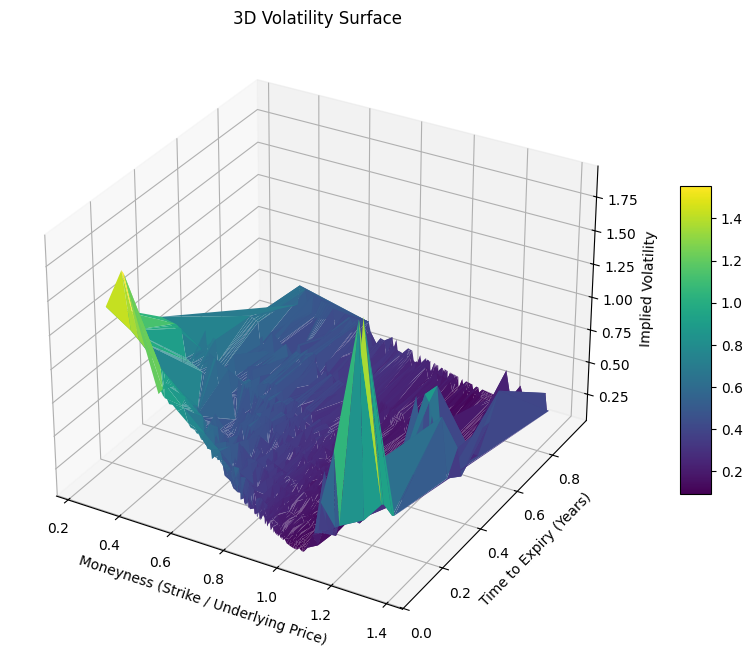

In [144]:
subset = options_df[options_df['ticker'] == 'SPY'].dropna(subset=['impliedVolatility'])

# Set up figure
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare data
X = subset['moneyness']
Y = subset['time_to_expiry']
Z = subset['impliedVolatility']

# Create 3D surface plot using trisurf
surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', linewidth=0.2, antialiased=True)

# Labels
ax.set_xlabel('Moneyness (Strike / Underlying Price)')
ax.set_ylabel('Time to Expiry (Years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('3D Volatility Surface')

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

# DBSCAN

In [159]:
options_df

,strike,bid,ask,mid_price,option_type,expiration,impliedVolatility,underlying_price,time_to_expiry,ticker,moneyness,cluster
1513,245.0,386.28,388.92,387.600,call,2025-08-15,1.775880,632.724976,0.060274,SPY,0.387214,-1.0
1514,250.0,381.23,384.00,382.615,call,2025-08-15,1.757814,632.724976,0.060274,SPY,0.395116,-1.0
1515,325.0,306.43,309.24,307.835,call,2025-08-15,0.949219,632.724976,0.060274,SPY,0.513651,0.0
1516,330.0,301.56,304.26,302.910,call,2025-08-15,0.983399,632.724976,0.060274,SPY,0.521554,-1.0
1517,335.0,296.49,299.29,297.890,call,2025-08-15,0.950196,632.724976,0.060274,SPY,0.529456,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16435,40.0,4.35,4.55,4.450,call,2026-07-17,0.386481,37.143101,0.980822,KWEB,1.076916,0.0
16436,41.0,4.00,4.20,4.100,call,2026-07-17,0.385626,37.143101,0.980822,KWEB,1.103839,0.0
16454,36.0,3.90,4.10,4.000,put,2026-07-17,0.322394,37.143101,0.980822,KWEB,0.969224,0.0
16455,38.0,4.90,5.10,5.000,put,2026-07-17,0.314460,37.143101,0.980822,KWEB,1.023070,0.0


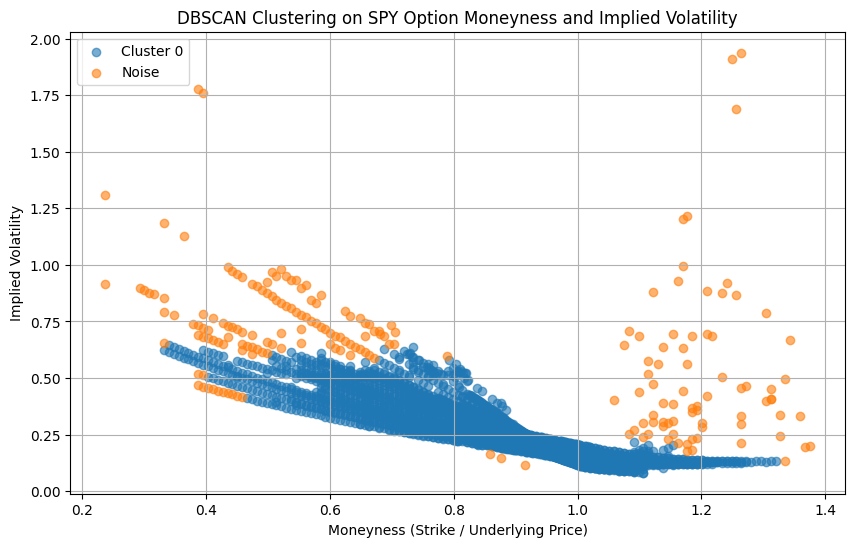

cluster
 0.0    3383
-1.0     199
Name: count, dtype: int64
        moneyness                                                              \
            count      mean       std       min       25%       50%       75%   
cluster                                                                         
-1.0        199.0  0.773586  0.352525  0.237070  0.462286  0.632186  1.153740   
 0.0       3383.0  0.870978  0.156874  0.331898  0.790233  0.892963  0.970406   

                  impliedVolatility            ...                      \
              max             count      mean  ...       75%       max   
cluster                                        ...                       
-1.0     1.375005             199.0  0.654988  ...  0.791811  1.937256   
 0.0     1.319689            3383.0  0.262021  ...  0.328177  0.646000   

        time_to_expiry                                                    \
                 count      mean       std       min       25%       50%   
cluster    

In [170]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

#  Filter for only SPY
spy_df = options_df[options_df['ticker'] == 'SPY'].copy()

features = spy_df[['moneyness', 'impliedVolatility']].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

db = DBSCAN(eps=0.2, min_samples=10).fit(X_scaled)

spy_df.loc[features.index, 'cluster'] = db.labels_

plt.figure(figsize=(10, 6))
for label in set(db.labels_):
    clustered = spy_df[spy_df['cluster'] == label]
    plt.scatter(clustered['moneyness'], clustered['impliedVolatility'],
                label=f'Cluster {int(label)}' if label != -1 else 'Noise', alpha=0.6)

plt.xlabel('Moneyness (Strike / Underlying Price)')
plt.ylabel('Implied Volatility')
plt.title('DBSCAN Clustering on SPY Option Moneyness and Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()

print(spy_df['cluster'].value_counts())
summary = spy_df.groupby('cluster')[['moneyness', 'impliedVolatility', 'time_to_expiry']].describe()
print(summary)


# Isolation

In [171]:
core_df = spy_df[spy_df['cluster'] == 0].copy()


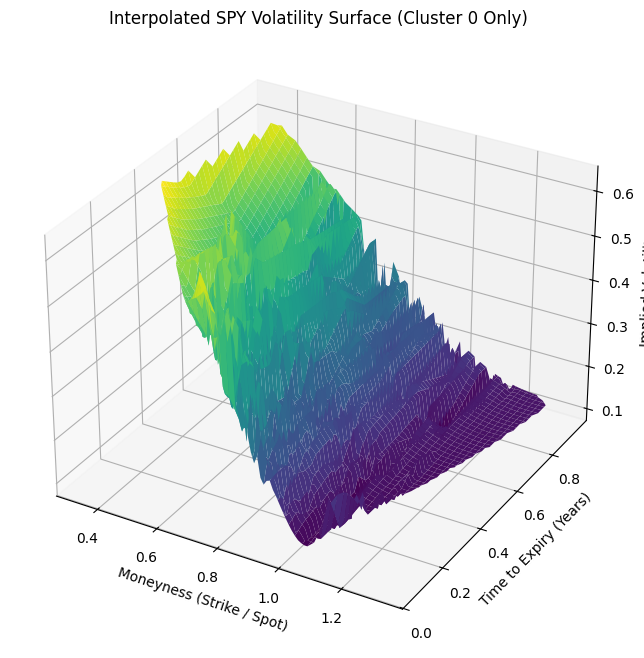

In [172]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

# Extract values
X = core_df['moneyness'].values
Y = core_df['time_to_expiry'].values
Z = core_df['impliedVolatility'].values

# Create a grid to interpolate onto
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate the surface
zi = griddata((X, Y), Z, (xi, yi), method='linear')

# Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')

ax.set_xlabel('Moneyness (Strike / Spot)')
ax.set_ylabel('Time to Expiry (Years)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Interpolated SPY Volatility Surface (Cluster 0 Only)')
plt.show()


# SVI for Single Option Expiry date

Fitted SVI Parameters for expiry 2025-08-15:
a: 0.0002, b: 0.0589, rho: -0.3130, m: -0.0588, sigma: 0.0266
Optimization Success: True
Message: Optimization terminated successfully
Arbitrage Constraint (2 - b*sigma*(1+|rho|)): 1.9979 (should be >= 0)


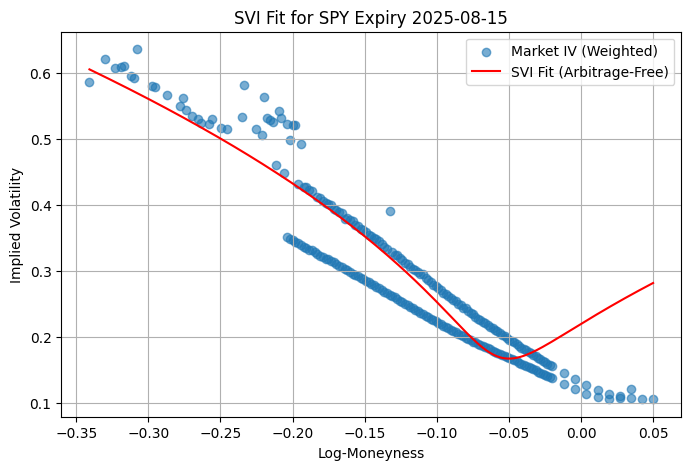

In [282]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Filter SPY Cluster 0 data
cluster0 = spy_df[spy_df['cluster'] == 0].copy()

# Get the first expiry group
expiry = cluster0['expiration'].min()
group = cluster0[cluster0['expiration'] == expiry].copy()

# Prepare log-moneyness and total variance
group['log_moneyness'] = np.log(group['strike'] / group['underlying_price'])
group['total_variance'] = (group['impliedVolatility'] ** 2) * group['time_to_expiry']

k = group['log_moneyness'].values
w_market = group['total_variance'].values

# SVI function
def svi_total_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Objective function for least squares
def svi_loss(params):
    a, b, rho, m, sigma = params
    # Note: The if np.inf check is now redundant because bounds handle parameter ranges.
    # We rely on bounds and constraints for valid parameters.

    w_model = svi_total_variance(k, a, b, rho, m, sigma)
    
    # Weight more for points near ATM (log-moneyness k near 0)
    # The 0.05 controls the width of the bell curve; smaller values make it sharper around 0.
    weights = np.exp(-k**2 / 0.05) 
    
    # Use np.average for weighted mean
    return np.average((w_model - w_market)**2, weights=weights)

# --- Define the Arbitrage-Free Constraint ---
def arbitrage_constraint(params):
    a, b, rho, m, sigma = params
    # Constraint: b * sigma * (1 + |rho|) <= 2
    # Reformulate as: 2 - b * sigma * (1 + |rho|) >= 0 (for scipy.optimize.minimize 'ineq' constraint)
    return 2 - b * sigma * (1 + np.abs(rho))







# Initial guess

bounds = [
    (1e-6, 1),        # a (non-negative)
    (1e-6, 10),       # b (positive)
    (-0.999, 0.999),  # rho (must be between -1 and 1)
    (-1.0, 1.0),      # m (log-moneyness center)
    (1e-6, 1.0),      # sigma (strictly positive)
]
initial_params = [
    0.01,        # a: average total variance
    0.24,                      # b: higher to give more flexibility
    -0.3,                      # rho: initially flat
    -0.1,              # m: center of log-moneyness
    0.15         # sigma: width of smile
]
constraints = ({'type': 'ineq', 'fun': arbitrage_constraint})

# Perform the minimization with bounds AND constraints
result = minimize(svi_loss, initial_params, method='SLSQP', bounds=bounds, constraints=constraints)
# Note: 'L-BFGS-B' does not support general inequality constraints. 'SLSQP' does.

# Extract fitted params
a, b, rho, m, sigma = result.x

print(f"Fitted SVI Parameters for expiry {expiry}:")
print(f"a: {a:.4f}, b: {b:.4f}, rho: {rho:.4f}, m: {m:.4f}, sigma: {sigma:.4f}")
print(f"Optimization Success: {result.success}")
print(f"Message: {result.message}")

# Check the arbitrage constraint value with fitted parameters
constraint_value = arbitrage_constraint(result.x)
print(f"Arbitrage Constraint (2 - b*sigma*(1+|rho|)): {constraint_value:.4f} (should be >= 0)")


# Generate fitted curve
k_fit = np.linspace(min(k), max(k), 200)
w_fit = svi_total_variance(k_fit, a, b, rho, m, sigma)
iv_fit = np.sqrt(w_fit / group['time_to_expiry'].iloc[0])

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(k, group['impliedVolatility'], label='Market IV (Weighted)', alpha=0.6)
plt.plot(k_fit, iv_fit, label='SVI Fit (Arbitrage-Free)', color='red')
plt.xlabel('Log-Moneyness')
plt.ylabel('Implied Volatility')
plt.title(f'SVI Fit for SPY Expiry {expiry}')
plt.legend()
plt.grid(True)
plt.show()


# SVI For Loop

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -- SVI TOTAL VARIANCE FUNCTION --
def svi_total_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# -- SVI LOSS FUNCTION --
def svi_loss(params, k, w_market):
    a, b, rho, m, sigma = params
    w_model = svi_total_variance(k, a, b, rho, m, sigma)
    weights = np.exp(-k**2 / 0.05)  # emphasize ATM
    return np.average((w_model - w_market)**2, weights=weights)

# -- ARBITRAGE CONSTRAINT --
def arbitrage_constraint(params):
    a, b, rho, m, sigma = params
    return 2 - b * sigma * (1 + np.abs(rho))  # should be ≥ 0

# -- PARAMETER SETUP --
bounds = [
    (1e-6, 1.0),        # a
    (1e-6, 10.0),       # b
    (-0.999, 0.999),    # rho
    (-1.0, 1.0),        # m
    (1e-6, 1.0),        # sigma
]
initial_params = [0.01, 0.2, -0.3, -0.1, 0.15]
constraints = ({'type': 'ineq', 'fun': arbitrage_constraint})

# -- PREPARE DATA --
core_df = spy_df[spy_df['cluster'] == 0].copy()
core_df['log_moneyness'] = np.log(core_df['strike'] / core_df['underlying_price'])
core_df['total_variance'] = (core_df['impliedVolatility']**2) * core_df['time_to_expiry']

# -- LOOP THROUGH EXPIRIES --
unique_expiries = sorted(core_df['expiration'].unique())
fitted_svi_params = []

print(f"\nStarting SVI fitting for {len(unique_expiries)} unique expiries...")

for expiry_date in unique_expiries:
    group = core_df[core_df['expiration'] == expiry_date].copy()

    if len(group) < 10:
        continue

    k_slice = group['log_moneyness'].values
    w_market_slice = group['total_variance'].values
    time_to_expiry = group['time_to_expiry'].iloc[0]

    try:
        result = minimize(svi_loss, initial_params,
                          args=(k_slice, w_market_slice),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints,
                          options={'disp': False, 'ftol': 1e-8})

        if result.success:
            a, b, rho, m, sigma = result.x
            fitted_svi_params.append({
                'expiration': expiry_date,
                'time_to_expiry': time_to_expiry,
                'a': a,
                'b': b,
                'rho': rho,
                'm': m,
                'sigma': sigma,
                'loss': result.fun,
                'constraint_value': arbitrage_constraint(result.x)
            })

    except Exception as e:
        print(f"Error for expiry {expiry_date}: {e}")
        continue

# -- OUTPUT --
fitted_params_df = pd.DataFrame(fitted_svi_params)

if not fitted_params_df.empty:
    print(f"\n Successfully fitted {len(fitted_params_df)} expiries.")
    print(fitted_params_df.head())
    fitted_params_df.to_csv('fitted_svi_params_spy.csv', index=False)
    print("📁 Saved to: fitted_svi_params_spy.csv")
else:
    print("\n No expiries successfully fitted.")



Starting SVI fitting for 16 unique expiries...

✅ Successfully fitted 16 expiries.
   expiration  time_to_expiry         a         b       rho         m  \
0  2025-08-15        0.060274  0.000001  0.052829 -0.310692 -0.051318   
1  2025-08-22        0.079452  0.000001  0.047385 -0.316425 -0.022454   
2  2025-08-29        0.098630  0.000001  0.052490 -0.315359 -0.023200   
3  2025-09-19        0.156164  0.000001  0.070787 -0.325773  0.002345   
4  2025-09-30        0.186301  0.000001  0.064688 -0.321139  0.006456   

      sigma      loss  constraint_value  
0  0.034693  0.000003          1.997598  
1  0.038729  0.000003          1.997584  
2  0.046289  0.000003          1.996804  
3  0.029177  0.000016          1.997262  
4  0.058356  0.000009          1.995013  
📁 Saved to: fitted_svi_params_spy.csv


/opt/anaconda3/envs/env_comm/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/env_comm/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/envs/env_comm/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


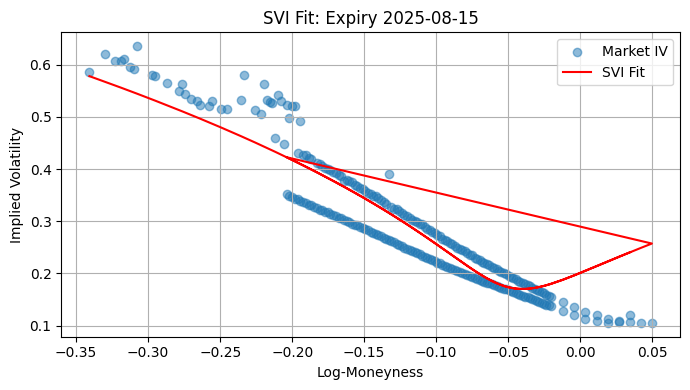

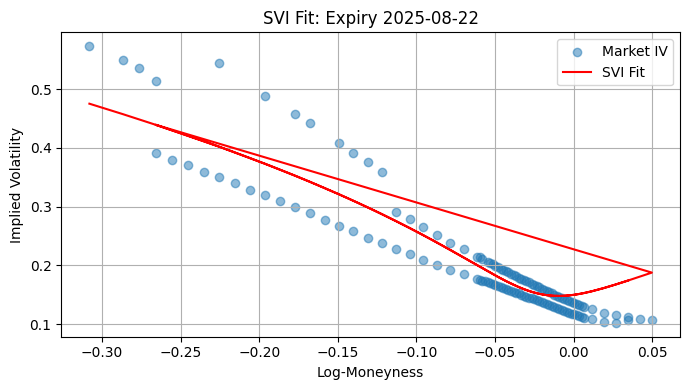

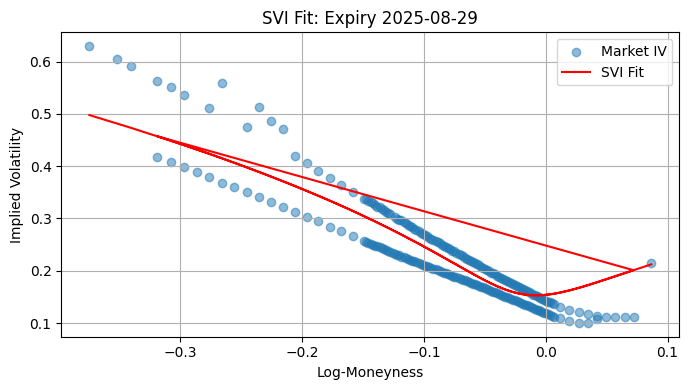

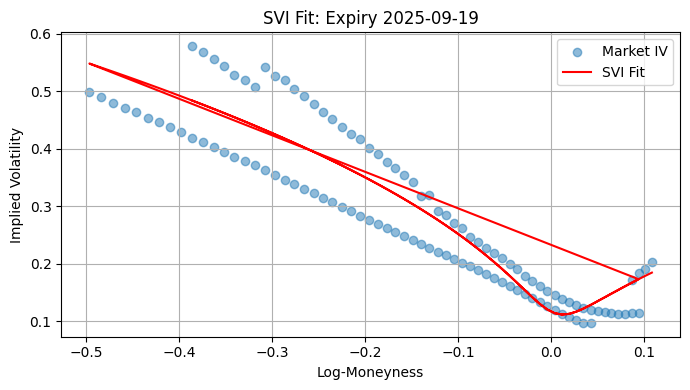

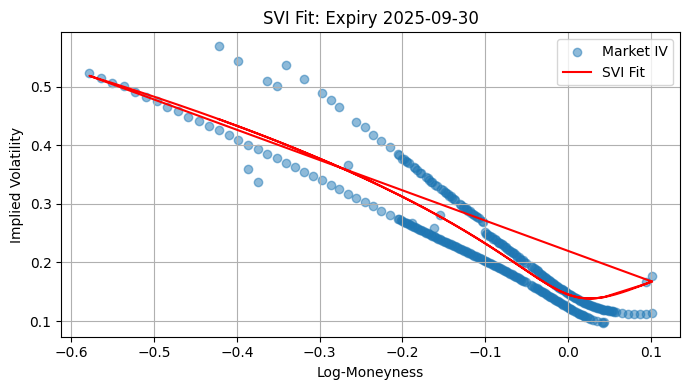

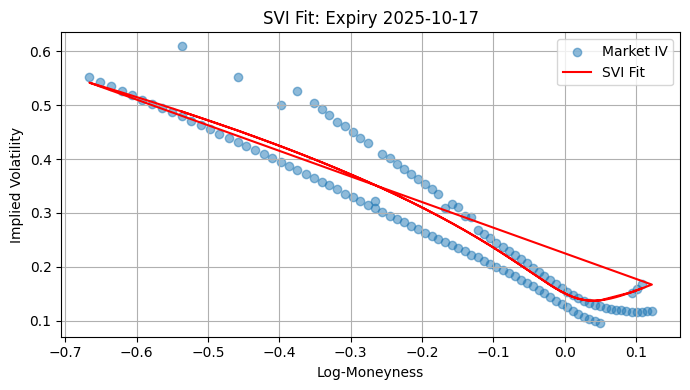

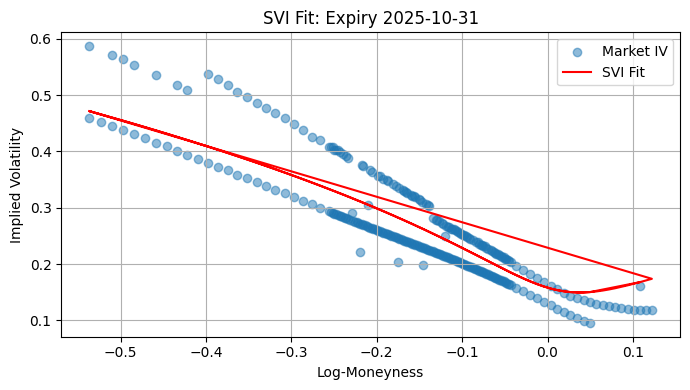

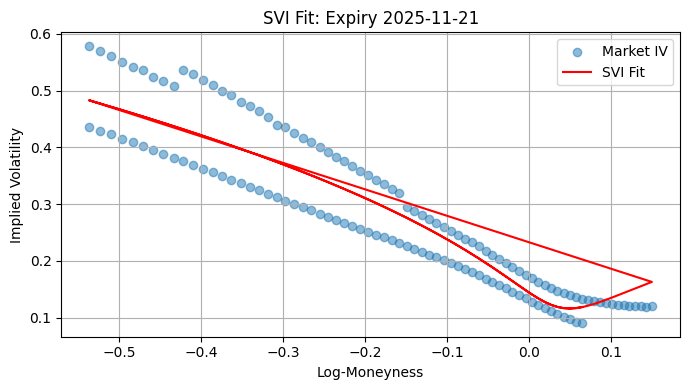

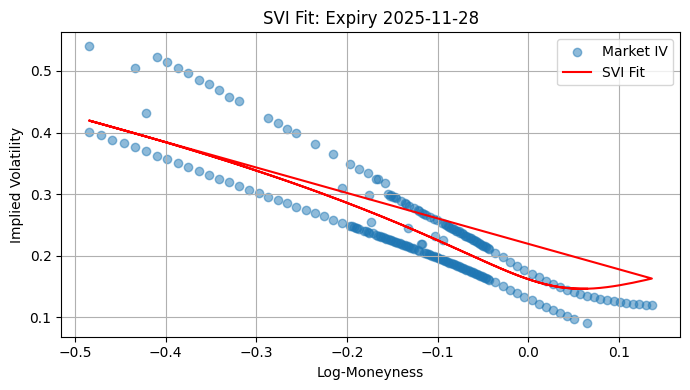

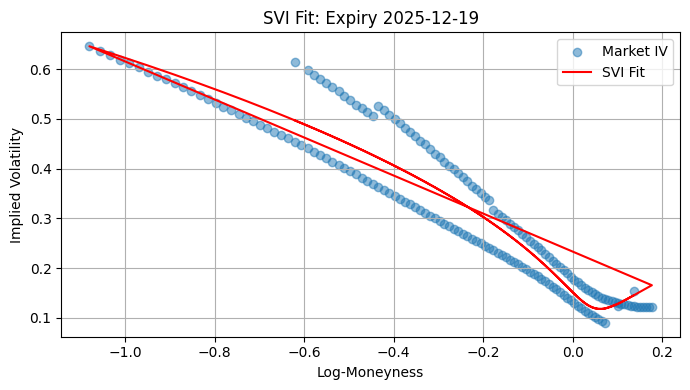

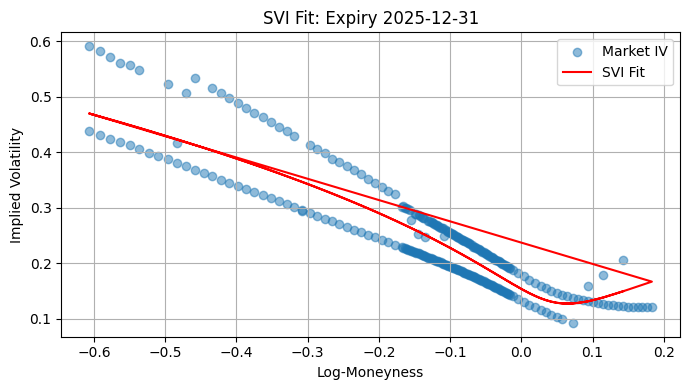

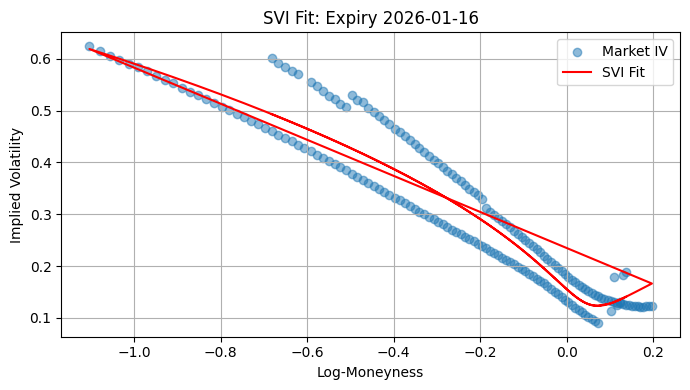

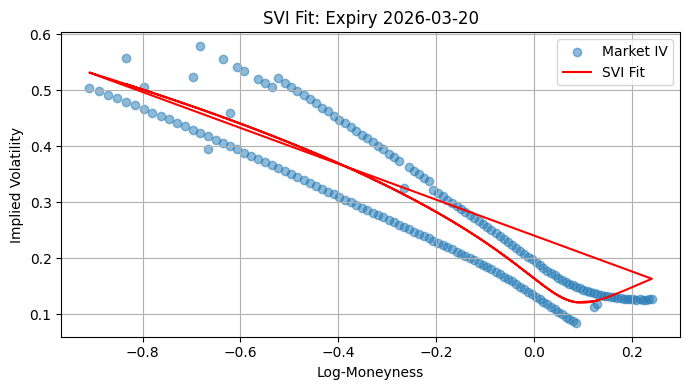

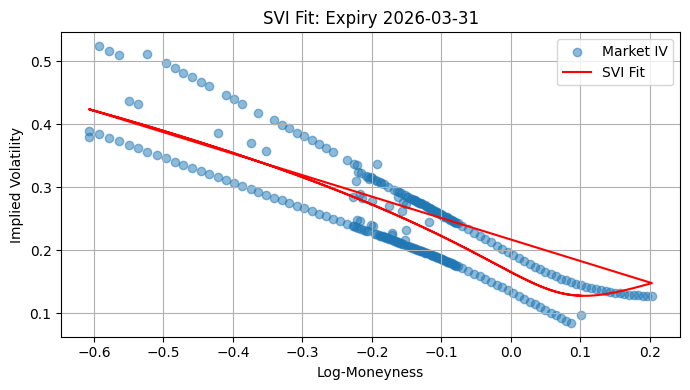

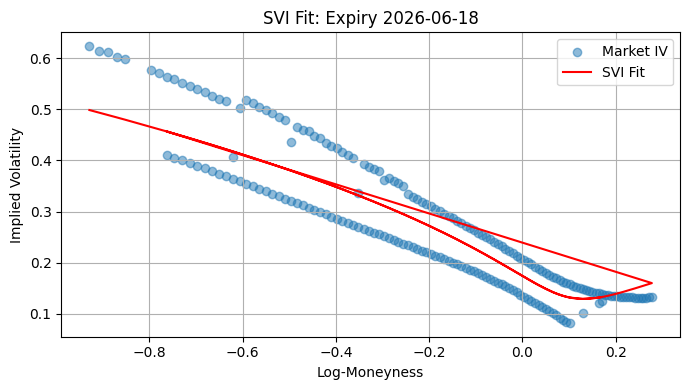

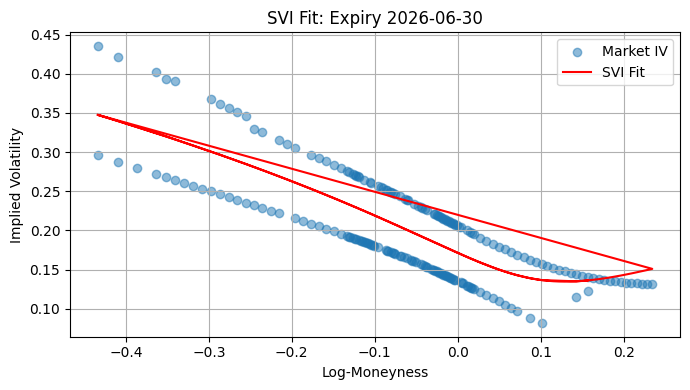

In [289]:
# For each fitted expiry, visualize the fit
for i, row in fitted_params_df.iterrows():
    group = core_df[core_df['expiration'] == row['expiration']]
    k = group['log_moneyness'].values
    iv_market = group['impliedVolatility'].values
    w_fit = svi_total_variance(k, row['a'], row['b'], row['rho'], row['m'], row['sigma'])
    iv_fit = np.sqrt(w_fit / row['time_to_expiry'])

    plt.figure(figsize=(7, 4))
    plt.scatter(k, iv_market, label='Market IV', alpha=0.5)
    plt.plot(k, iv_fit, label='SVI Fit', color='red')
    plt.title(f"SVI Fit: Expiry {row['expiration']}")
    plt.xlabel('Log-Moneyness')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


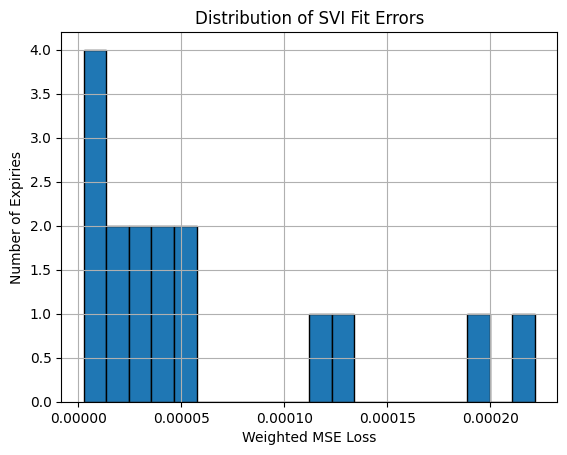

In [290]:
plt.hist(fitted_params_df['loss'], bins=20, edgecolor='black')
plt.title("Distribution of SVI Fit Errors")
plt.xlabel("Weighted MSE Loss")
plt.ylabel("Number of Expiries")
plt.grid(True)
plt.show()


In [291]:
print(fitted_params_df[['expiration', 'loss', 'constraint_value']].sort_values(by='loss').head(10))


    expiration      loss  constraint_value
1   2025-08-22  0.000003          1.997584
0   2025-08-15  0.000003          1.997598
2   2025-08-29  0.000003          1.996804
4   2025-09-30  0.000009          1.995013
3   2025-09-19  0.000016          1.997262
5   2025-10-17  0.000016          1.993864
6   2025-10-31  0.000027          1.991511
8   2025-11-28  0.000032          1.989496
7   2025-11-21  0.000038          1.993708
10  2025-12-31  0.000041          1.989984


Text(0.5, 0, 'Implied Volatility')

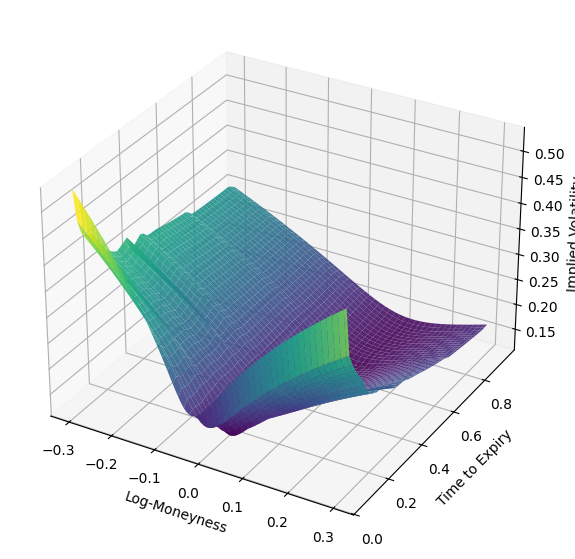

In [294]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Define a grid
k_vals = np.linspace(-0.3, 0.3, 100)  # log-moneyness
t_vals = np.linspace(fitted_params_df['time_to_expiry'].min(), 
                     fitted_params_df['time_to_expiry'].max(), 50)  # time to expiry

K, T = np.meshgrid(k_vals, t_vals)
IV_surface = np.zeros_like(K)

# Interpolate SVI parameters across maturities
from scipy.interpolate import interp1d

# Create interpolators for each SVI parameter
param_funcs = {}
for param in ['a', 'b', 'rho', 'm', 'sigma']:
    interp_func = interp1d(fitted_params_df['time_to_expiry'], fitted_params_df[param],
                           kind='linear', fill_value="extrapolate")
    param_funcs[param] = interp_func

# Fill IV_surface
for i in range(T.shape[0]):
    for j in range(K.shape[1]):
        t = T[i, j]
        k = K[i, j]
        a = param_funcs['a'](t)
        b = param_funcs['b'](t)
        rho = param_funcs['rho'](t)
        m = param_funcs['m'](t)
        sigma = param_funcs['sigma'](t)
        
        w = svi_total_variance(k, a, b, rho, m, sigma)
        iv = np.sqrt(w / t)
        IV_surface[i, j] = iv

# Plot surface
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K, T, IV_surface, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.9)

ax.set_xlabel('Log-Moneyness')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Implied Volatility')


# Heston